My attempt at reproducing Dave's `snodka` function. Dave's function will be wrong when the atmosphere is changing faster than a scan.

After the first half of the notebook, I try to do it on a per cycle basis and use `dysh` functions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u

from dysh.spectra import core as sc
from dysh.spectra.scan import GBTTPScan
from dysh.fits.gbtfitsload import GBTFITSLoad

In [3]:
def parse_query(query, op="and"):
    """ Takes a dictionary with keys as SDFITS columns
    and whose values are a tuple with the condition and 
    the required value and concatenates them using the
    `op` operator.
    """
    q = ""
    for i,(k,v) in enumerate(query.items()):
        q += f"{k} {v[0]} {v[1]} "
        if i < len(query) - 1:
            q += f"{op} "
    return q


def select_rows(df, query, op="and"):
    """ Returns a list with the rows of a `pandas.DataFrame`
    that fulfill the query.
    See `parse_query` for details on how to define the query.
    """

    q = parse_query(query, op=op)
    return np.array(list(df.query(q).index))


def tsys_vec(cal_on, cal_off, fedge=10, ch0=None, chf=None):
    """
    """

    nchan = cal_on["DATA"].shape[1]
    if ch0 == None:
        ch0 = nchan // fedge
    if chf == None:
        chf = nchan - ch0 + 1
    chrng = slice(ch0,chf,1)

    tcal = cal_on["TCAL"]
    meanoff = cal_off["DATA"][:,chrng]
    meandiff = cal_on["DATA"][:,chrng] - cal_off["DATA"][:,chrng]

    tsys = ( meanoff / meandiff * tcal[:,np.newaxis] + tcal[:,np.newaxis]/2.0 )

    return tsys

In [4]:
path = "/home/dysh/example_data/subbeamnod-Ka/"
sdf_file = f"{path}/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits"

In [5]:
sdf = GBTFITSLoad(sdf_file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dysh/example_data/subbeamnod-Ka//data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits'

In [ ]:
# Define what we are calibrating.
scan = 43
ifnum = 0
fdnum = 1 # Remember that Ka is special because its beams are switched! It is now fixed, yay!
plnum = 0
bintable = 0
w = "tsys"
docal = True

# Select data.
q = {"SCAN": ("in", f"[{scan}]"), 
     "IFNUM": ("in", f"[{ifnum}]"), 
     "FDNUM": ("in", f"[{fdnum}]"), 
     "PLNUM": ("==", plnum), 
     "SUBREF_STATE": ("==", -1)}
sig_rows = select_rows(sdf._ptable[bintable], q)
q = {"SCAN": ("in", f"[{scan}]"), 
     "IFNUM": ("in", f"[{ifnum}]"), 
     "FDNUM": ("in", f"[{fdnum}]"), 
     "PLNUM": ("==", plnum), 
     "SUBREF_STATE": ("==", 1)}
ref_rows = select_rows(sdf._ptable[bintable], q)

# Average.
def time_average(table):
    wt = np.empty(len(table), dtype='d')
    wt[:] = table["EXPOSURE"].astype('d')*abs(table["CDELT1"]).astype('d')/table["TSYS"].astype('d')
    return np.average(table["DATA"], axis=0, weights=wt)

ref_avg = time_average(sdf._hdu[bintable+1].data[ref_rows])
sig_avg = time_average(sdf._hdu[bintable+1].data[sig_rows])

# Get TSYS.
fulltp = sdf.gettp(scan,sig=None,cal=None,
                    bintable=bintable,fdnum=fdnum,
                    plnum=plnum,ifnum=ifnum,
                    weight=w,calibrate=docal).timeaverage(weights=w)

# Good old calibration.
cal = (sig_avg - ref_avg)/ref_avg * fulltp.meta['TSYS']

# Now we should make a new SDFITS row with the calibrated data 
# and the corresponding updated data and metadata.

In [6]:
# Open the result from GBTIDL.
gbtidl_file = f"{path}/outputs/snodka_scan_43_fdnum_1_plnum_0.fits"
hdu_ = fits.open(gbtidl_file)
gbtidl_sbn = hdu_[1].data["DATA"][0]

FileNotFoundError: [Errno 2] No such file or directory: '/home/dysh/example_data/subbeamnod-Ka//outputs/snodka_scan_43_fdnum_1_plnum_0.fits'

In [7]:
# Compare.
diff = cal - gbtidl_sbn
print(f"Mean diff: {np.nanmean(diff)}")
print(f"Median diff: {np.nanmedian(diff)}")

# Allways look at it.
plt.figure()
plt.subplot(211)
plt.plot(cal, label="dysh")
plt.plot(gbtidl_sbn, alpha=0.5, label="GBTIDL")
plt.legend()
plt.ylabel("Antenna temperature (K)")
plt.xlabel("Channel number")
plt.subplot(212)
plt.plot(cal - gbtidl_sbn, c='k')
plt.ylabel("Difference (K)")
plt.xlabel("Channel number");

NameError: name 'cal' is not defined

Now, the correct way of doing this is to actually do the calibration per cycle. Also, take care that you pair signal and reference cycles properly, specially if you have less reference cycles.

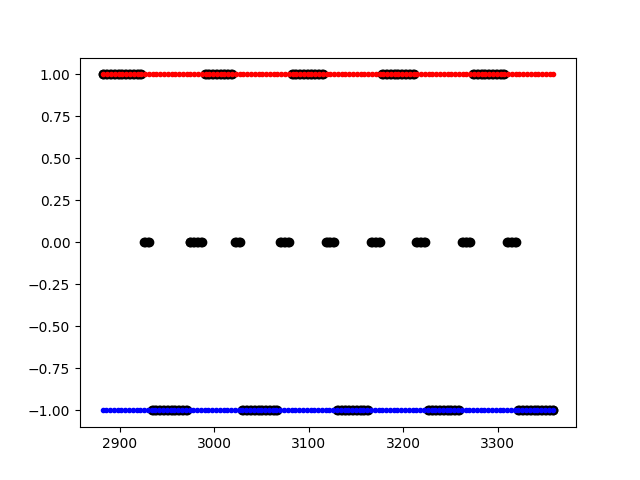

In [9]:
# Select data.
q = {"SCAN": ("in", f"[{scan}]"), 
     "IFNUM": ("in", f"[{ifnum}]"), 
     "FDNUM": ("in", f"[{fdnum}]"), 
     "PLNUM": ("==", plnum)}
rows = select_rows(sdf._ptable[bintable], q)

plt.figure()
plt.plot(rows, sdf._hdu[bintable+1].data[rows]["SUBREF_STATE"], 'ko')
calon = (sdf._hdu[bintable+1].data[rows]["CAL"]=="T")
plt.plot(rows[calon], np.ones(calon.sum()), "r.")
caloff = (sdf._hdu[bintable+1].data[rows]["CAL"]=="F")
plt.plot(rows[caloff], -np.ones(caloff.sum()), "b.")


In [10]:
q = {"SCAN": ("in", f"[{scan}]"), 
     "IFNUM": ("in", f"[{ifnum}]"), 
     "FDNUM": ("in", f"[{fdnum}]"), 
     "PLNUM": ("==", plnum), 
     "SUBREF_STATE": ("==", -1),
     "CAL": ("==", "'T'")}
sig_on_rows = select_rows(sdf._ptable[bintable], q)
q.update({"CAL": ("==", "'F'")})
sig_off_rows = select_rows(sdf._ptable[bintable], q)
q.update({"SUBREF_STATE": ("==", 1)})
ref_off_rows = select_rows(sdf._ptable[bintable], q)
q.update({"CAL": ("==", "'T'")})
ref_on_rows = select_rows(sdf._ptable[bintable], q)

In [11]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) >= stepsize)[0]+1)

In [12]:
# This should be tested in more cases.
stepsize = len(sdf.udata(0,"IFNUM"))*len(sdf.udata(0,"PLNUM"))*2 + 1
stepsize

5

In [13]:
ref_on_groups = consecutive(ref_on_rows, stepsize=stepsize)
sig_on_groups = consecutive(sig_on_rows, stepsize=stepsize)
ref_off_groups = consecutive(ref_off_rows, stepsize=stepsize)
sig_off_groups = consecutive(sig_off_rows, stepsize=stepsize)

In [14]:
# Test case.
if False:
    print(len(ref_on_groups))
    del ref_on_groups[-1]
    del ref_on_groups[-1]
    print(len(ref_on_groups))

In [15]:
# Make sure we have enough signal and reference pairs.
# Same number of cycles or less signal cycles.
if len(sig_on_groups) <= len(ref_on_groups):
    pairs = {i : i for i in range(len(sig_on_groups))}
# One more signal cycle. Re-use one reference cycle.
elif len(sig_on_groups) - 1 == len(ref_on_groups):
    pairs = {i : i for i in range(len(sig_on_groups))}
    pairs[len(sig_on_groups) - 1] = len(ref_on_groups) - 1
else:
    e = f"""There are {len(sig_on_groups)} and {len(ref_on_groups)} signal and reference cycles.
            Try using the per-scan option"""
    raise ValueError(e)
pairs

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [16]:
nchan = int(sdf._ptable[bintable]["TDIM7"][0][1:-1].split(",")[0])
ta = np.empty((len(sig_on_groups)), dtype=object)
ta_avg = np.zeros(nchan, dtype='d')
wt_avg = 0.0 #np.empty(nchan, dtype='d')
groups_zip = zip(ref_on_groups, sig_on_groups, ref_off_groups, sig_off_groups)

for i,(rgon,sgon,rgoff,sgoff) in enumerate(groups_zip):
    
    # #print(rgon)
    # ref_on = sdf._hdu[bintable+1].data[rgon]
    # ref_off = sdf._hdu[bintable+1].data[rgoff]
    # tcal = ref_on["TCAL"]
    # tsys = tsys_vec(ref_on, ref_off) #sc.mean_tsys(ref_on["DATA"], ref_off["DATA"], tcal, fedge=10)
    # #tsys_ = np.array([sc.mean_tsys(ref_on["DATA"][i], ref_off["DATA"][i], tcal[0]) for i in range(len(rgon))])
    # ref_on["TSYS"] = tsys.mean(axis=1)
    # ref_off["TSYS"] = tsys.mean(axis=1)
    # ref_on_avg = time_average(ref_on)
    # ref_off_avg = time_average(ref_off)
    # ref_avg = (ref_on_avg + ref_off_avg)
    # #ref = 
    
    # Do it the dysh way.
    calrows = {"ON": rgon, "OFF": rgoff}
    tprows = np.sort(np.hstack((rgon, rgoff)))
    reftp = GBTTPScan(sdf,43,"BOTH","BOTH",tprows,calrows,0,True)
    ref_avg = reftp.timeaverage()
    calrows = {"ON": sgon, "OFF": sgoff}
    tprows = np.sort(np.hstack((sgon, sgoff)))
    sigtp = GBTTPScan(sdf,43,"BOTH","BOTH",tprows,calrows,0,True)
    sig_avg = sigtp.timeaverage()
    # Combine sig and ref.
    ta[i] = deepcopy(sig_avg)
    ta[i] = ta[i].new_flux_unit("K", suppress_conversion=True)
    ta[i]._data = ((sig_avg - ref_avg)/ref_avg).flux.value * ref_avg.meta['WTTSYS'] * u.K
    ta[i].meta["TUNIT7"] = "Ta"
    ta[i].meta["TSYS"] = ref_avg.meta['WTTSYS']

    wt_avg += ta[i].meta["TSYS"]**-2.
    ta_avg[:] += ta[i].flux.value * ta[i].meta["TSYS"]**-2.

ta_avg = ta_avg / wt_avg

TPSCAN nrows = 22
# scanrows 22, # calrows ON 11  # calrows OFF 11
TPSCAN nrows = 20
# scanrows 20, # calrows ON 10  # calrows OFF 10
TPSCAN nrows = 16
# scanrows 16, # calrows ON 8  # calrows OFF 8
TPSCAN nrows = 20
# scanrows 20, # calrows ON 10  # calrows OFF 10
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 20
# scanrows 20, # calrows ON 10  # calrows OFF 10


In [21]:
# For fun, lets also try the current dysh version.
sbn = sdf.subbeamnod(43, sig=None, cal=None,
                     ifnum=0, fdnum=1, calibrate=True,
                     weights='tsys')

TPSCAN nrows = 96
# scanrows 96, # calrows ON 48  # calrows OFF 48
TPSCAN nrows = 92
# scanrows 92, # calrows ON 46  # calrows OFF 46
TPSCAN nrows = 240
# scanrows 240, # calrows ON 120  # calrows OFF 120


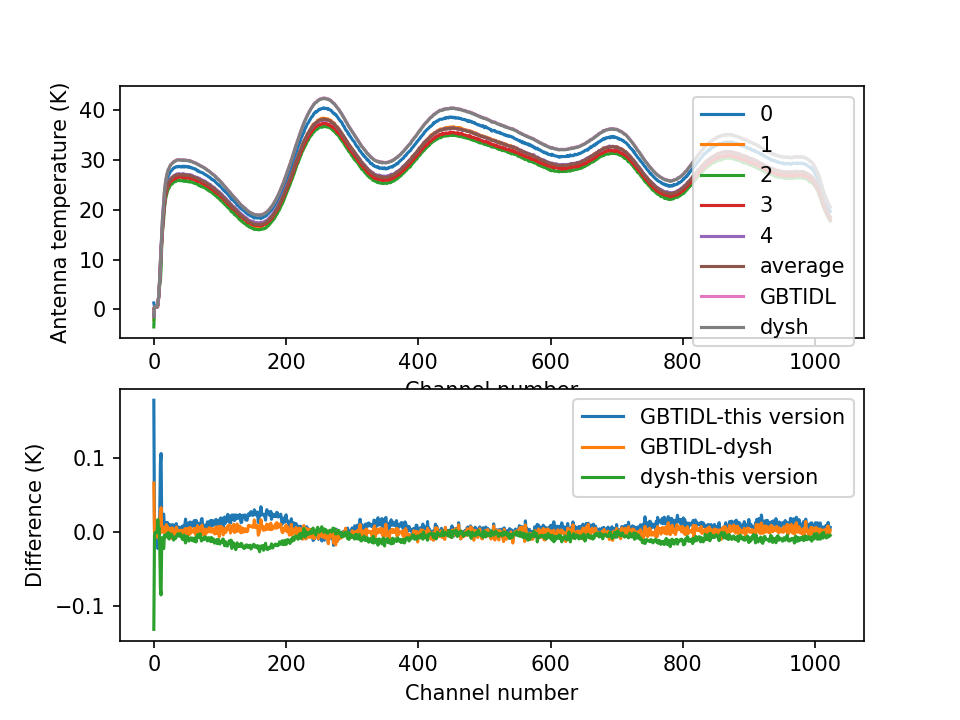

In [23]:
plt.figure(dpi=150)
plt.subplot(211)
for i in range(len(ta)):
    plt.plot(ta[i].flux.value, label=i)
plt.plot(ta_avg, label='average')
plt.plot(gbtidl_sbn, label="GBTIDL")
plt.plot(sbn.flux.value, label="dysh")
plt.legend()
plt.xlabel("Channel number")
plt.ylabel("Antenna temperature (K)")
plt.subplot(212)
plt.plot(gbtidl_sbn/np.nanmax(gbtidl_sbn)*np.nanmax(ta_avg) - ta_avg, label="GBTIDL-this version")
plt.plot(gbtidl_sbn/np.nanmax(gbtidl_sbn)*np.nanmax(sbn.flux.value) - sbn.flux.value, label="GBTIDL-dysh")
plt.plot(ta_avg/np.nanmax(ta_avg)*np.nanmax(sbn.flux.value) - sbn.flux.value, label="dysh-this version")
plt.legend()
plt.xlabel("Channel number")
plt.ylabel("Difference (K)");

rms in this version: 0.12472985499045765
rms in dysh version: 0.1381052050972909
rms in dysh version: 0.1377940162370563


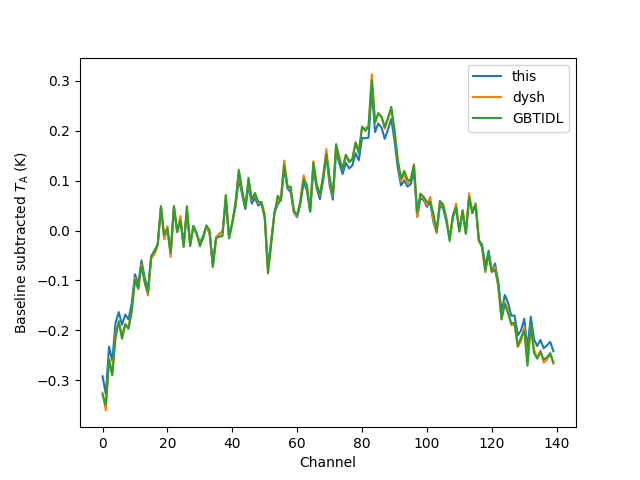

In [32]:
# Which one is less noisy?
x = np.arange(nchan)
s = slice(460,600,1)

pfit = np.polyfit(x[s], ta_avg[s], 1)
pval = np.poly1d(pfit)(x[s])
ta_ = ta_avg[s] - pval
print(f"rms in this version: {ta_.std()}")

pfit = np.polyfit(x[s], sbn.flux.value.astype('d')[s], 1)
pval = np.poly1d(pfit)(x[s])
sbn_ = sbn.flux.value[s] - pval
print(f"rms in dysh version: {sbn_.std()}")

pfit = np.polyfit(x[s], gbtidl_sbn[s], 1)
pval = np.poly1d(pfit)(x[s])
gbtidl_ = gbtidl_sbn[s] - pval
print(f"rms in dysh version: {gbtidl_.std()}")

plt.figure()
plt.plot(ta_, label="this")
plt.plot(sbn_, label="dysh")
plt.plot(gbtidl_, label="GBTIDL")
plt.xlabel("Channel")
plt.ylabel(r"Baseline subtracted $T_{\rm{A}}$ (K)")
plt.legend();

In the end, they all seem to perform similarly. To really understand which one is better, we should use synthetic data.